本文用于vgg模型在mnist，fashion_mnist数据集上的超参数调优。由于vgg16，vgg19要求图片最小像素是$32\times32$的RGB图片，而mnist，fashion_mnist图片是$28\times28$的灰度图片，所以下面对vgg16进行了一定的裁剪。

## 基本程序

下面引入要使用的包，然后定义一些后面将要使用的函数。

In [10]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf
import time

from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.keras import datasets, models, Model, layers, callbacks, losses, optimizers, preprocessing
from tensorboard.plugins.hparams import api as hp

# 设置日志
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)]
)

# 保存模型的loss, accuracy等指标
models = {}

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
class TaskTime:
    '''用于显示执行时间'''
    
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))
        
def get_weight_num(model):
    '''得到模型可训练参数的个数'''
    return np.sum([np.prod(p.shape) for p in model.trainable_weights])

def show_images(images, labels, x_num=6, y_num=6, figsize=(8,8), classes=None):
    '''显示图片'''
    plt.figure(figsize=figsize)
    channel_count = images.shape[-1]
    for i in range(x_num*y_num):
        plt.subplot(x_num, y_num, i+1)
        if channel_count==1:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        label = labels[i] if classes is None else classes[labels[i]]
        plt.title("{}".format(label))
        plt.xticks([])
        plt.yticks([])    

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)      
    plt.show()
    
def show_tree(path, max_depth=10, max_num=100):
    def _show_tree(path, depth, max_num, prefix):
        if max_num<=0 or depth>max_depth:
            return max_num
        if depth==1: 
            print(path)
            max_num=max_num-1
        items = os.listdir(path)
        for i, item in enumerate(items):
            if max_num<=0: return max_num
            newitem = path +'/'+ item
            if i==len(items)-1:
                print(prefix  + "└──" + item)            
                new_prefix = prefix+"    "                
            else:
                print(prefix  + "├──" + item)
                new_prefix = prefix+"│   "
            max_num=max_num-1
            if os.path.isdir(newitem):
                max_num = _show_tree(newitem, depth=depth+1, max_num=max_num, prefix=new_prefix)         
        return max_num
    _show_tree(path, depth=1, max_num=max_num, prefix="")    
    
def load_best_checkpoint(model):
    '''加载最佳的checkpoint'''
    model.load_weights(model.checkpoint_path)
    return model    

def get_dataset(data, batch_size=32):
    (train_images, train_labels), (test_images, test_labels) = data
    
    train_val_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)) 
    train_val_size = train_images.shape[0]
    # reshuffle_each_iteration必须设置成False，否则train_dataset和val_dataset会有重复
    train_val_dataset = train_val_dataset.shuffle(train_val_size, reshuffle_each_iteration = False)  

    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.batch(batch_size)

    train_size = int(0.9*train_val_size)
    train_dataset = train_val_dataset.take(train_size)
    train_dataset = train_dataset.shuffle(train_size, reshuffle_each_iteration = True) 
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = train_val_dataset.skip(train_size)
    val_dataset = val_dataset.shuffle(train_val_size-train_size, reshuffle_each_iteration = True)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

    input_shape = train_dataset.element_spec[0].shape[1:]

    return input_shape, train_dataset, val_dataset, test_dataset

## 加载数据

In [12]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1)
train_images = train_images/255.0
test_images = test_images/255.0

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

data = ((train_images, train_labels), (test_images, test_labels))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


In [13]:
input_shape, train_dataset, val_dataset, test_dataset = get_dataset(data, 32)

2020-12-22 11:23:35,505: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:23:35,506: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:23:35,507: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:23:35,509: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:23:35,510: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:23:35,511: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 11:23:35,540: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:23:35,541: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:23:35,542: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:23:35,543: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:23:35,545: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:23:35,546: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


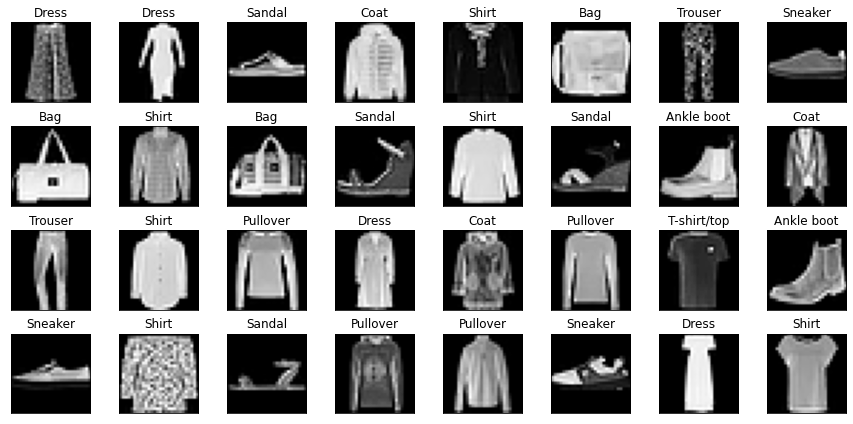

In [14]:
images, labels = iter(train_dataset).next()
show_images(images, labels, x_num=4, y_num=8, figsize=(12, 6), classes=classes)

## 超参数调优

### BatchNormalization和Dropout

首先来小试牛刀，看看BatchNormalization和Dropout在模型中的作用。

In [15]:
METRIC_ACCURACY = 'accuracy'
METRIC_LOSS = 'loss'


HP_DENSE_LAYER_COUNT = hp.HParam("DENSE_LAYER_COUNT", hp.Discrete([1]))
HP_DENSE_LAYER_UNITS  = hp.HParam("DENSE_LAYER_UNITS", hp.Discrete([128]))
HP_LEARNING_RATE = hp.HParam("LEARNING_RATE", hp.Discrete([0.001]))
HP_VGG_BLOCK_COUNT = hp.HParam("VGG_BLOCK_COUNT", hp.Discrete([3]))
HP_DROPOUT_RATE = hp.HParam("DROPOUT_RATE", hp.Discrete([-1.0, 0.3]))
HP_USE_BN = hp.HParam("USE_BN", hp.Discrete([False, True]))
HP_START_FILTERS = hp.HParam("START_FILTERS", hp.Discrete([32]))
HP_BATCH_SIZE = hp.HParam("BATCH_SIZE", hp.Discrete([32]))



def show_hparams(hparams):
    for params in hparams:
        print('-'*25, params.name, '-'*25,)
        for param_value in params.domain.values:
            print(param_value)
        
    
def intial_hparams(logs_path):
    if os.path.exists(logs_path):
        if os.path.isdir(logs_path): 
            shutil.rmtree(logs_path)
        else:
            os.remove(logs_path)
            
    hparams=[HP_DENSE_LAYER_COUNT, HP_DENSE_LAYER_UNITS, HP_LEARNING_RATE, HP_VGG_BLOCK_COUNT, 
             HP_DROPOUT_RATE, HP_USE_BN, HP_START_FILTERS, HP_BATCH_SIZE]
    with tf.summary.create_file_writer(logs_path).as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'),
                     hp.Metric(METRIC_LOSS, display_name='Loss')
                    ],
        )
    show_hparams(hparams)   
    return logs_path
                              

In [19]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, 
              use_dropout=True, drop_out_rate=0.3):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)
    return x
    

def get_model(model_name,
              input_shape,
              dense_layer_count=1, 
              dense_layer_units=64,
              learning_rate=0.001,
              vgg_block_count=3,
              use_bn=True, 
              drop_out_rate=0,
              start_filters=32
             ):   
    input = layers.Input(shape=input_shape)
    use_dropout = drop_out_rate>0
    
    filters = start_filters
    x = input
    for i in range(vgg_block_count):
        x = get_block(x, filters, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
        filters = filters*2
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if use_dropout: x = layers.Dropout(drop_out_rate)(x)     
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=model_name) 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model 

def get_simple_hparams(hparams):
    return {key.name:value for key, value in hparams.items()}

def train_evaluate_model(run_name, data, hparams, epochs, verbose=True):
    def get_model_(input_shape):
        model = get_model(model_name=run_name,
                          input_shape=input_shape,
                          dense_layer_count=hparams[HP_DENSE_LAYER_COUNT], 
                          dense_layer_units=hparams[HP_DENSE_LAYER_UNITS],
                          learning_rate=hparams[HP_LEARNING_RATE],
                          vgg_block_count=hparams[HP_VGG_BLOCK_COUNT],
                          use_bn=hparams[HP_USE_BN], 
                          drop_out_rate=hparams[HP_DROPOUT_RATE],
                          start_filters=hparams[HP_START_FILTERS]
                         )
        model.compile(optimizer=optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
                      loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=["accuracy"],
        )        
        return model
    batch_size = hparams[HP_BATCH_SIZE]
    input_shape, train_dataset, val_dataset, test_dataset = get_dataset(data, batch_size)     
    
    model = get_model_(input_shape)
    model.summary()
    
    checkpoint_best_only = callbacks.ModelCheckpoint(filepath=model.checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_weights_only=True, 
                                                     save_best_only=True,
                                                     verbose=False)
    # reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001, patience=4, verbose=verbose) 
    early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6)    
    
    with TaskTime('training', True) as t: 
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, verbose=verbose, 
                  callbacks=[checkpoint_best_only, early_stopping])
        # history = model.fit(train_dataset, validation_data=val_dataset, validation_steps=100, epochs=epochs, verbose=verbose, 
        #          callbacks=[checkpoint_best_only, early_stopping])        
        history.train_time = t.elapsed_time()
    
    model = get_model_(input_shape)
    model.load_weights(model.checkpoint_path)    
    loss, accuracy = simple_evaluate_show(model, 
                                          train_time=history.train_time,
                                          train_dataset=train_dataset, 
                                          val_dataset=val_dataset, 
                                          test_dataset=test_dataset,
                                          hparams=get_simple_hparams(hparams),
                  models=models
                 )       
    return loss, accuracy

def run(run_name, data, run_dir, hparams, epochs):
    with tf.summary.create_file_writer(run_dir).as_default():
        print('-'*120)
        hp.hparams(hparams) 
        loss, accuracy = train_evaluate_model(run_name, data, hparams, epochs)     
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1) 
        tf.summary.scalar(METRIC_LOSS, loss, step=1) 
        print('Test Loss: {:0.4f}, Test accuracy: {:0.2%}'.format(loss, accuracy))
    

def run_all(logs_path, data, epochs=5):
    session_num = 0

    for dense_layer_count in HP_DENSE_LAYER_COUNT.domain.values:
        for dense_layer_units in HP_DENSE_LAYER_UNITS.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                for vgg_block_count in HP_VGG_BLOCK_COUNT.domain.values:
                    for drop_out_rate in HP_DROPOUT_RATE.domain.values:  
                        for use_bn in HP_USE_BN.domain.values:
                            for start_filters in HP_START_FILTERS.domain.values:
                                for batch_size in HP_BATCH_SIZE.domain.values:                            
                          
                                    hparams = {
                                        HP_DENSE_LAYER_COUNT: dense_layer_count,
                                        HP_DENSE_LAYER_UNITS: dense_layer_units,
                                        HP_LEARNING_RATE: learning_rate,
                                        HP_VGG_BLOCK_COUNT: vgg_block_count,
                                        HP_DROPOUT_RATE: drop_out_rate,                                
                                        HP_USE_BN: use_bn,
                                        HP_START_FILTERS: start_filters,
                                        HP_BATCH_SIZE: batch_size
                                    }

                                    run_name = "%d" % (session_num+1)
                                    with TaskTime('trial: %s' % run_name, True) as t: 
                                        print({h.name: hparams[h] for h in hparams})
                                        run(run_name, data, os.path.join(logs_path, run_name), hparams, epochs)
                                        session_num += 1    
                                
def simple_evaluate_show(model, train_time, 
                  train_dataset, 
                  val_dataset, 
                  test_dataset, 
                  hparams,
                  models):
    '''评估当前模型，并且显示所有模型的信息'''
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=False)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=False)
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=False)
    if  model.name not in models or models[model.name]['test_accuracy']<test_accuracy:
        models[model.name] = {'train_loss':round(train_loss, 6), 
                              'train_accuracy':round(train_accuracy, 4), 
                              'val_loss':round(val_loss, 6), 
                              'val_accuracy':round(val_accuracy, 4),    
                              'test_loss':round(test_loss, 6), 
                              'test_accuracy':round(test_accuracy, 4),                               
                              'weight_number':get_weight_num(model), 
                              'model':model,
                              'train_time':round(train_time,0),
                              'hparams':hparams
                             }    
    simple_show_models(models)  
    return test_loss, test_accuracy    

def simple_show_models(models, topn=50):     
    '''按照test_accuracy倒序显示所有模型的信息'''
    models_remove1 = {key:{key1:value1 for key1, value1 in value.items() if  key1 in ['test_loss', 'test_accuracy', 'hparams']} 
                      for key, value in models.items()}
    df_models = pd.DataFrame.from_dict(models_remove1, orient='index')
    df_models = df_models.sort_values('test_accuracy', ascending=False)  
    pd.set_option('display.max_colwidth', 200)
    if topn is not None: df_models=df_models.head(topn)
    display(df_models)
    


In [17]:
models = {}
logs_path = intial_hparams('logs/vgg_hparam_tuning')   
run_all(logs_path, data=data, epochs=20)

2020-12-22 11:23:38,310: INFO: start trial: 1


------------------------- DENSE_LAYER_COUNT -------------------------
1
------------------------- DENSE_LAYER_UNITS -------------------------
128
------------------------- LEARNING_RATE -------------------------
0.001
------------------------- VGG_BLOCK_COUNT -------------------------
3
------------------------- DROPOUT_RATE -------------------------
-1.0
0.3
------------------------- USE_BN -------------------------
False
True
------------------------- START_FILTERS -------------------------
32
------------------------- BATCH_SIZE -------------------------
32
{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:23:38,709: INFO: start training


Model: "1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 64)          0         

2020-12-22 11:26:22,848: INFO: finish training [elapsed time: 164.14 seconds]


,test_loss,test_accuracy,hparams
1,0.266676,0.9235,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2667, Test accuracy: 92.35%


2020-12-22 11:26:29,213: INFO: finish trial: 1 [elapsed time: 170.90 seconds]
2020-12-22 11:26:29,214: INFO: start trial: 2


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:26:29,666: INFO: start training


Model: "2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 64)        36928     

2020-12-22 11:30:28,515: INFO: finish training [elapsed time: 238.85 seconds]


,test_loss,test_accuracy,hparams
1,0.266676,0.9235,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.412554,0.9222,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.4126, Test accuracy: 92.22%


2020-12-22 11:30:34,957: INFO: finish trial: 2 [elapsed time: 245.74 seconds]
2020-12-22 11:30:34,958: INFO: start trial: 3


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:30:35,335: INFO: start training


Model: "3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 64)        36928     

2020-12-22 11:33:09,569: INFO: finish training [elapsed time: 154.23 seconds]


,test_loss,test_accuracy,hparams
3,0.224299,0.9247,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.266676,0.9235,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.412554,0.9222,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2243, Test accuracy: 92.47%


2020-12-22 11:33:15,691: INFO: finish trial: 3 [elapsed time: 160.73 seconds]
2020-12-22 11:33:15,692: INFO: start trial: 4


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:33:16,135: INFO: start training


Model: "4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 14, 14, 64)        18496     

2020-12-22 11:36:04,460: INFO: finish training [elapsed time: 168.33 seconds]


,test_loss,test_accuracy,hparams
4,0.204819,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.224299,0.9247,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.266676,0.9235,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.412554,0.9222,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2048, Test accuracy: 93.11%


2020-12-22 11:36:10,821: INFO: finish trial: 4 [elapsed time: 175.13 seconds]


上面测试结果表明，BatchNormalization和Dropout可以显著减少过拟合，所以下面测试中，默认Enable这两个参数，只是还需要寻找dropout_rate的一个合理值。

In [18]:
show_tree(logs_path, max_num=30)
simple_show_models(models)

logs/vgg_hparam_tuning
├──events.out.tfevents.1608608084.b7fbff9a047a.30574.45341.v2
├──1
│   └──events.out.tfevents.1608608084.b7fbff9a047a.30574.45356.v2
├──2
│   └──events.out.tfevents.1608608207.b7fbff9a047a.30574.110658.v2
├──3
│   └──events.out.tfevents.1608608374.b7fbff9a047a.30574.192744.v2
└──4
    └──events.out.tfevents.1608608532.b7fbff9a047a.30574.273181.v2


,test_loss,test_accuracy,hparams
4,0.196441,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.391378,0.9286,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.210768,0.9243,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.280538,0.9212,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': -1.0, 'USE_BN': False, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


In [19]:
# ! tensorboard --logdir {logs_path} --bind_all

打开 http://15.15.166.35:16006/

### 全面测试

In [20]:
HP_DENSE_LAYER_COUNT = hp.HParam("DENSE_LAYER_COUNT", hp.Discrete([1, 2]))
HP_DENSE_LAYER_UNITS  = hp.HParam("DENSE_LAYER_UNITS", hp.Discrete([128, 256]))
HP_LEARNING_RATE = hp.HParam("LEARNING_RATE", hp.Discrete([0.0005, 0.001, 0.002]))
HP_VGG_BLOCK_COUNT = hp.HParam("VGG_BLOCK_COUNT", hp.Discrete([2, 3, 4]))
HP_DROPOUT_RATE = hp.HParam("DROPOUT_RATE", hp.Discrete([0.2, 0.3, 0.4]))    
HP_USE_BN = hp.HParam("USE_BN", hp.Discrete([True]))
HP_START_FILTERS = hp.HParam("START_FILTERS", hp.Discrete([32]))
HP_BATCH_SIZE = hp.HParam("BATCH_SIZE", hp.Discrete([32]))

In [22]:
models = {}
logs_path = intial_hparams('logs/vgg_hparam_tuning_full')   
run_all(logs_path, data=data, epochs=20)

2020-12-22 03:46:36,858: INFO: start trial: 1


------------------------- DENSE_LAYER_COUNT -------------------------
1
2
------------------------- DENSE_LAYER_UNITS -------------------------
128
256
------------------------- LEARNING_RATE -------------------------
0.0005
0.001
0.002
------------------------- VGG_BLOCK_COUNT -------------------------
2
3
4
------------------------- DROPOUT_RATE -------------------------
0.2
0.3
0.4
------------------------- USE_BN -------------------------
True
------------------------- START_FILTERS -------------------------
32
------------------------- BATCH_SIZE -------------------------
32
{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:46:37,329: INFO: start training


Model: "1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 14, 14, 64)        18496     

2020-12-22 03:48:54,336: INFO: finish training [elapsed time: 137.01 seconds]


,test_loss,test_accuracy,hparams
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2578, Test accuracy: 93.02%


2020-12-22 03:49:00,274: INFO: finish trial: 1 [elapsed time: 143.42 seconds]
2020-12-22 03:49:00,275: INFO: start trial: 2


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:49:00,669: INFO: start training


Model: "2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 03:49:08,816: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 03:49:08,817: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 03:49:08,819: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 03:49:08,820: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 03:49:08,821: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 03:49:08,822: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 03:49:08,866: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 03:49:08,867: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 03:49:08,869: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 03:49:08,870: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 03:49:08,871: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 03:49:08,872: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 03:49:08,967: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 03:49:08,969: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 03:49:08,970: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 03:49:08,971: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 03:49:08,972: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 03:49:08,973: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 03:49:09,049: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 03:49:09,050: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 03:49:09,051: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 03:49:09,052: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 03:49:09,053: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 03:49:09,055: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


1687/1687 [==============================] - 7s 4ms/step - loss: 0.5376 - accuracy: 0.8068 - val_loss: 0.3103 - val_accuracy: 0.8841
Epoch 2/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.3484 - accuracy: 0.8724 - val_loss: 0.2632 - val_accuracy: 0.9031
Epoch 3/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.3031 - accuracy: 0.8891 - val_loss: 0.2348 - val_accuracy: 0.9162
Epoch 4/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.2640 - accuracy: 0.9036 - val_loss: 0.2216 - val_accuracy: 0.9241
Epoch 5/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.2488 - accuracy: 0.9080 - val_loss: 0.2213 - val_accuracy: 0.9253
Epoch 6/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.2332 - accuracy: 0.9151 - val_loss: 0.2149 - val_accuracy: 0.9247
Epoch 7/20
1687/1687 [==============================] - 6s 4ms/step - loss: 0.2181 - accuracy: 0.9195 - val_loss: 0.2024 - val_accuracy: 0.9300
Epo

2020-12-22 03:51:18,774: INFO: finish training [elapsed time: 138.10 seconds]


,test_loss,test_accuracy,hparams
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2037, Test accuracy: 92.97%


2020-12-22 03:51:24,673: INFO: finish trial: 2 [elapsed time: 144.40 seconds]
2020-12-22 03:51:24,675: INFO: start trial: 3


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:51:25,074: INFO: start training


Model: "3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 03:53:42,461: INFO: finish training [elapsed time: 137.39 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2033, Test accuracy: 93.14%


2020-12-22 03:53:48,242: INFO: finish trial: 3 [elapsed time: 143.57 seconds]
2020-12-22 03:53:48,243: INFO: start trial: 4


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:53:48,685: INFO: start training


Model: "4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 03:56:33,829: INFO: finish training [elapsed time: 165.14 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2059, Test accuracy: 92.95%


2020-12-22 03:56:40,342: INFO: finish trial: 4 [elapsed time: 172.10 seconds]
2020-12-22 03:56:40,344: INFO: start trial: 5


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:56:40,879: INFO: start training


Model: "5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 03:59:01,772: INFO: finish training [elapsed time: 140.89 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1998, Test accuracy: 92.83%


2020-12-22 03:59:08,210: INFO: finish trial: 5 [elapsed time: 147.87 seconds]
2020-12-22 03:59:08,211: INFO: start trial: 6


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 03:59:08,649: INFO: start training


Model: "6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_48 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 04:01:54,735: INFO: finish training [elapsed time: 166.09 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1996, Test accuracy: 93.11%


2020-12-22 04:02:01,055: INFO: finish trial: 6 [elapsed time: 172.84 seconds]
2020-12-22 04:02:01,056: INFO: start trial: 7


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:02:01,558: INFO: start training


Model: "7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_54 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 04:05:28,032: INFO: finish training [elapsed time: 206.47 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2444, Test accuracy: 92.80%


2020-12-22 04:05:35,055: INFO: finish trial: 7 [elapsed time: 214.00 seconds]
2020-12-22 04:05:35,056: INFO: start trial: 8


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:05:35,551: INFO: start training


Model: "8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_62 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 04:09:01,216: INFO: finish training [elapsed time: 205.66 seconds]


,test_loss,test_accuracy,hparams
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
8,0.192078,0.9279,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1921, Test accuracy: 92.79%


2020-12-22 04:09:08,225: INFO: finish trial: 8 [elapsed time: 213.17 seconds]
2020-12-22 04:09:08,226: INFO: start trial: 9


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:09:08,722: INFO: start training


Model: "9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_70 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 04:12:35,886: INFO: finish training [elapsed time: 207.16 seconds]


,test_loss,test_accuracy,hparams
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
8,0.192078,0.9279,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1956, Test accuracy: 93.25%


2020-12-22 04:12:42,988: INFO: finish trial: 9 [elapsed time: 214.76 seconds]
2020-12-22 04:12:42,990: INFO: start trial: 10


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:12:43,390: INFO: start training


Model: "10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_78 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:14:40,275: INFO: finish training [elapsed time: 116.89 seconds]


,test_loss,test_accuracy,hparams
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
8,0.192078,0.9279,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
10,0.224952,0.9270,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2250, Test accuracy: 92.70%


2020-12-22 04:14:46,036: INFO: finish trial: 10 [elapsed time: 123.05 seconds]
2020-12-22 04:14:46,037: INFO: start trial: 11


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:14:46,430: INFO: start training


Model: "11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_82 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:17:03,068: INFO: finish training [elapsed time: 136.64 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
8,0.192078,0.9279,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1998, Test accuracy: 93.52%


2020-12-22 04:17:08,986: INFO: finish trial: 11 [elapsed time: 142.95 seconds]
2020-12-22 04:17:08,987: INFO: start trial: 12


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:17:09,380: INFO: start training


Model: "12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_86 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:19:26,387: INFO: finish training [elapsed time: 137.01 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.244418,0.9280,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1989, Test accuracy: 93.11%


2020-12-22 04:19:32,278: INFO: finish trial: 12 [elapsed time: 143.29 seconds]
2020-12-22 04:19:32,279: INFO: start trial: 13


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:19:32,722: INFO: start training


Model: "13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_90 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_122 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:22:17,984: INFO: finish training [elapsed time: 165.26 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.199810,0.9283,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2276, Test accuracy: 93.09%


2020-12-22 04:22:24,449: INFO: finish trial: 13 [elapsed time: 172.17 seconds]
2020-12-22 04:22:24,450: INFO: start trial: 14


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:22:24,893: INFO: start training


Model: "14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_240 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_96 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_130 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:25:10,430: INFO: finish training [elapsed time: 165.54 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2018, Test accuracy: 93.07%


2020-12-22 04:25:16,809: INFO: finish trial: 14 [elapsed time: 172.36 seconds]
2020-12-22 04:25:16,810: INFO: start trial: 15


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:25:17,252: INFO: start training


Model: "15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_102 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_138 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:28:02,088: INFO: finish training [elapsed time: 164.84 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
4,0.205931,0.9295,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2022, Test accuracy: 92.90%


2020-12-22 04:28:08,386: INFO: finish trial: 15 [elapsed time: 171.58 seconds]
2020-12-22 04:28:08,387: INFO: start trial: 16


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:28:08,970: INFO: start training


Model: "16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_108 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_146 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:31:15,553: INFO: finish training [elapsed time: 186.58 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2089, Test accuracy: 93.10%


2020-12-22 04:31:22,699: INFO: finish trial: 16 [elapsed time: 194.31 seconds]
2020-12-22 04:31:22,700: INFO: start trial: 17


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:31:23,198: INFO: start training


Model: "17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_280 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_281 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_116 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_156 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:33:48,099: INFO: finish training [elapsed time: 144.90 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
2,0.203701,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2146, Test accuracy: 92.23%


2020-12-22 04:33:55,166: INFO: finish trial: 17 [elapsed time: 152.47 seconds]
2020-12-22 04:33:55,167: INFO: start trial: 18


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:33:55,653: INFO: start training


Model: "18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_124 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_166 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:37:21,778: INFO: finish training [elapsed time: 206.12 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1981, Test accuracy: 93.20%


2020-12-22 04:37:29,489: INFO: finish trial: 18 [elapsed time: 214.32 seconds]
2020-12-22 04:37:29,490: INFO: start trial: 19


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:37:29,885: INFO: start training


Model: "19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_132 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_176 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:39:33,258: INFO: finish training [elapsed time: 123.37 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2344, Test accuracy: 92.63%


2020-12-22 04:39:39,059: INFO: finish trial: 19 [elapsed time: 129.57 seconds]
2020-12-22 04:39:39,061: INFO: start trial: 20


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:39:39,452: INFO: start training


Model: "20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_320 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_321 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_136 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_182 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_322 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:41:56,518: INFO: finish training [elapsed time: 137.07 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2059, Test accuracy: 92.91%


2020-12-22 04:42:02,471: INFO: finish trial: 20 [elapsed time: 143.41 seconds]
2020-12-22 04:42:02,472: INFO: start trial: 21


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:42:02,869: INFO: start training


Model: "21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_329 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_140 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_188 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:44:19,846: INFO: finish training [elapsed time: 136.98 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.257789,0.9302,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2156, Test accuracy: 92.85%


2020-12-22 04:44:25,760: INFO: finish trial: 21 [elapsed time: 143.29 seconds]
2020-12-22 04:44:25,762: INFO: start trial: 22


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:44:26,217: INFO: start training


Model: "22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_336 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_337 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_144 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_338 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:47:20,300: INFO: finish training [elapsed time: 174.08 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2247, Test accuracy: 93.31%


2020-12-22 04:47:26,787: INFO: finish trial: 22 [elapsed time: 181.02 seconds]
2020-12-22 04:47:26,788: INFO: start trial: 23


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:47:27,228: INFO: start training


Model: "23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_348 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_349 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_150 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_202 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_350 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:50:12,717: INFO: finish training [elapsed time: 165.49 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2010, Test accuracy: 93.05%


2020-12-22 04:50:19,178: INFO: finish trial: 23 [elapsed time: 172.39 seconds]
2020-12-22 04:50:19,180: INFO: start trial: 24


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:50:19,622: INFO: start training


Model: "24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_156 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_210 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:53:05,336: INFO: finish training [elapsed time: 165.71 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
14,0.201837,0.9307,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2210, Test accuracy: 92.07%


2020-12-22 04:53:12,100: INFO: finish trial: 24 [elapsed time: 172.92 seconds]
2020-12-22 04:53:12,102: INFO: start trial: 25


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:53:12,603: INFO: start training


Model: "25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_372 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_373 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_162 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_218 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:56:38,852: INFO: finish training [elapsed time: 206.25 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2241, Test accuracy: 93.17%


2020-12-22 04:56:45,836: INFO: finish trial: 25 [elapsed time: 213.73 seconds]
2020-12-22 04:56:45,837: INFO: start trial: 26


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:56:46,331: INFO: start training


Model: "26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_389 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_170 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_228 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 04:59:32,101: INFO: finish training [elapsed time: 165.77 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2222, Test accuracy: 92.47%


2020-12-22 04:59:39,109: INFO: finish trial: 26 [elapsed time: 173.27 seconds]
2020-12-22 04:59:39,110: INFO: start trial: 27


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 04:59:39,607: INFO: start training


Model: "27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_404 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_405 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_178 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_238 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_406 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:03:07,540: INFO: finish training [elapsed time: 207.93 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2086, Test accuracy: 92.98%


2020-12-22 05:03:14,845: INFO: finish trial: 27 [elapsed time: 215.74 seconds]
2020-12-22 05:03:14,847: INFO: start trial: 28


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:03:15,249: INFO: start training


Model: "28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_420 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_421 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_186 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_210 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_248 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:05:33,729: INFO: finish training [elapsed time: 138.48 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
13,0.227551,0.9309,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2170, Test accuracy: 92.95%


2020-12-22 05:05:39,695: INFO: finish trial: 28 [elapsed time: 144.85 seconds]
2020-12-22 05:05:39,696: INFO: start trial: 29


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:05:40,092: INFO: start training


Model: "29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_428 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_429 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_190 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_214 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_254 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_430 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:07:57,521: INFO: finish training [elapsed time: 137.43 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
16,0.208898,0.9310,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2222, Test accuracy: 93.27%


2020-12-22 05:08:03,536: INFO: finish trial: 29 [elapsed time: 143.84 seconds]
2020-12-22 05:08:03,537: INFO: start trial: 30


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:08:03,921: INFO: start training


Model: "30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_436 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_437 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_194 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_260 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_438 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:10:21,669: INFO: finish training [elapsed time: 137.75 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2031, Test accuracy: 93.14%


2020-12-22 05:10:27,743: INFO: finish trial: 30 [elapsed time: 144.21 seconds]
2020-12-22 05:10:27,744: INFO: start trial: 31


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:10:28,639: INFO: start training


Model: "31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_444 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_445 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_198 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_266 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_446 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:13:15,545: INFO: finish training [elapsed time: 166.91 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
12,0.198877,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2095, Test accuracy: 93.31%


2020-12-22 05:13:21,983: INFO: finish trial: 31 [elapsed time: 174.24 seconds]
2020-12-22 05:13:21,984: INFO: start trial: 32


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:13:22,418: INFO: start training


Model: "32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_456 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_457 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_204 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_228 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_274 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_458 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:15:43,727: INFO: finish training [elapsed time: 141.31 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2046, Test accuracy: 92.95%


2020-12-22 05:15:50,138: INFO: finish trial: 32 [elapsed time: 148.15 seconds]
2020-12-22 05:15:50,139: INFO: start trial: 33


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:15:50,574: INFO: start training


Model: "33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_468 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_210 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_234 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_282 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:18:36,728: INFO: finish training [elapsed time: 166.15 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1908, Test accuracy: 93.08%


2020-12-22 05:18:43,086: INFO: finish trial: 33 [elapsed time: 172.95 seconds]
2020-12-22 05:18:43,087: INFO: start trial: 34


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:18:43,574: INFO: start training


Model: "34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_480 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_481 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_216 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_240 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_290 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_482 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:22:10,046: INFO: finish training [elapsed time: 206.47 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.199628,0.9311,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2196, Test accuracy: 93.00%


2020-12-22 05:22:17,080: INFO: finish trial: 34 [elapsed time: 213.99 seconds]
2020-12-22 05:22:17,081: INFO: start trial: 35


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:22:17,581: INFO: start training


Model: "35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_496 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_497 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_224 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_248 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_300 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_498 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:25:44,482: INFO: finish training [elapsed time: 206.90 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2056, Test accuracy: 93.20%


2020-12-22 05:25:51,654: INFO: finish trial: 35 [elapsed time: 214.57 seconds]
2020-12-22 05:25:51,655: INFO: start trial: 36


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:25:52,140: INFO: start training


Model: "36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_512 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_513 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_232 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_256 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_310 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_514 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:29:18,823: INFO: finish training [elapsed time: 206.68 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2083, Test accuracy: 92.44%


2020-12-22 05:29:26,218: INFO: finish trial: 36 [elapsed time: 214.56 seconds]
2020-12-22 05:29:26,219: INFO: start trial: 37


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:29:26,634: INFO: start training


Model: "37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_528 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_529 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_240 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_264 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_320 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_530 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:31:44,666: INFO: finish training [elapsed time: 138.03 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
30,0.203138,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2070, Test accuracy: 93.47%


2020-12-22 05:31:50,524: INFO: finish trial: 37 [elapsed time: 144.31 seconds]
2020-12-22 05:31:50,525: INFO: start trial: 38


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:31:50,928: INFO: start training


Model: "38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_536 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_537 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_244 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_268 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_326 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_538 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:34:08,197: INFO: finish training [elapsed time: 137.27 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2170, Test accuracy: 92.81%


2020-12-22 05:34:14,024: INFO: finish trial: 38 [elapsed time: 143.50 seconds]
2020-12-22 05:34:14,026: INFO: start trial: 39


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:34:14,420: INFO: start training


Model: "39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_544 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_545 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_248 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_272 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_332 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_546 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:36:31,463: INFO: finish training [elapsed time: 137.04 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
3,0.203292,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2070, Test accuracy: 92.79%


2020-12-22 05:36:37,292: INFO: finish trial: 39 [elapsed time: 143.27 seconds]
2020-12-22 05:36:37,293: INFO: start trial: 40


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:36:37,740: INFO: start training


Model: "40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_95 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_552 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_553 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_252 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_338 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_554 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:39:22,948: INFO: finish training [elapsed time: 165.21 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2153, Test accuracy: 93.20%


2020-12-22 05:39:29,234: INFO: finish trial: 40 [elapsed time: 171.94 seconds]
2020-12-22 05:39:29,235: INFO: start trial: 41


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:39:29,679: INFO: start training


Model: "41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_97 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_564 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_565 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_258 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_282 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_346 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_566 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:42:14,784: INFO: finish training [elapsed time: 165.10 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2102, Test accuracy: 93.03%


2020-12-22 05:42:21,182: INFO: finish trial: 41 [elapsed time: 171.95 seconds]
2020-12-22 05:42:21,183: INFO: start trial: 42


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:42:21,622: INFO: start training


Model: "42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_576 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_577 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_264 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_288 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_354 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_578 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:45:06,748: INFO: finish training [elapsed time: 165.13 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
25,0.224147,0.9317,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1992, Test accuracy: 92.86%


2020-12-22 05:45:13,249: INFO: finish trial: 42 [elapsed time: 172.07 seconds]
2020-12-22 05:45:13,251: INFO: start trial: 43


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:45:13,743: INFO: start training


Model: "43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_588 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_589 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_270 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_294 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_362 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_590 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:48:39,742: INFO: finish training [elapsed time: 206.00 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2131, Test accuracy: 93.43%


2020-12-22 05:48:46,655: INFO: finish trial: 43 [elapsed time: 213.40 seconds]
2020-12-22 05:48:46,656: INFO: start trial: 44


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:48:47,142: INFO: start training


Model: "44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_103 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_604 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_605 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_278 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_302 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_372 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_606 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:51:52,745: INFO: finish training [elapsed time: 185.60 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2118, Test accuracy: 92.76%


2020-12-22 05:51:59,651: INFO: finish trial: 44 [elapsed time: 193.00 seconds]
2020-12-22 05:51:59,652: INFO: start trial: 45


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:52:00,158: INFO: start training


Model: "45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_620 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_621 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_286 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_310 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_382 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_622 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:55:27,731: INFO: finish training [elapsed time: 207.57 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2031, Test accuracy: 92.94%


2020-12-22 05:55:34,765: INFO: finish trial: 45 [elapsed time: 215.11 seconds]
2020-12-22 05:55:34,766: INFO: start trial: 46


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:55:35,153: INFO: start training


Model: "46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_107 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_636 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_637 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_294 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_318 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_392 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_638 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 05:57:52,579: INFO: finish training [elapsed time: 137.43 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2226, Test accuracy: 92.74%


2020-12-22 05:57:58,500: INFO: finish trial: 46 [elapsed time: 143.73 seconds]
2020-12-22 05:57:58,502: INFO: start trial: 47


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 05:57:58,895: INFO: start training


Model: "47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_644 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_645 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_298 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_322 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_398 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_646 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:00:15,829: INFO: finish training [elapsed time: 136.93 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2151, Test accuracy: 92.86%


2020-12-22 06:00:21,604: INFO: finish trial: 47 [elapsed time: 143.10 seconds]
2020-12-22 06:00:21,605: INFO: start trial: 48


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:00:22,001: INFO: start training


Model: "48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_652 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_653 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_302 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_326 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_404 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_654 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:02:39,146: INFO: finish training [elapsed time: 137.15 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2087, Test accuracy: 92.81%


2020-12-22 06:02:45,159: INFO: finish trial: 48 [elapsed time: 143.55 seconds]
2020-12-22 06:02:45,160: INFO: start trial: 49


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:02:45,598: INFO: start training


Model: "49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_113 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_660 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_661 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_306 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_330 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_410 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_662 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:05:30,266: INFO: finish training [elapsed time: 164.67 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
49,0.215488,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2155, Test accuracy: 93.20%


2020-12-22 06:05:36,610: INFO: finish trial: 49 [elapsed time: 171.45 seconds]
2020-12-22 06:05:36,611: INFO: start trial: 50


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:05:37,050: INFO: start training


Model: "50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_672 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_673 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_312 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_336 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_418 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_674 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:08:21,976: INFO: finish training [elapsed time: 164.93 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
49,0.215488,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2145, Test accuracy: 92.99%


2020-12-22 06:08:28,344: INFO: finish trial: 50 [elapsed time: 171.73 seconds]
2020-12-22 06:08:28,345: INFO: start trial: 51


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:08:28,792: INFO: start training


Model: "51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_684 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_685 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_318 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_342 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_426 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_686 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:11:13,727: INFO: finish training [elapsed time: 164.94 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
49,0.215488,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2037, Test accuracy: 93.06%


2020-12-22 06:11:20,208: INFO: finish trial: 51 [elapsed time: 171.86 seconds]
2020-12-22 06:11:20,209: INFO: start trial: 52


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:11:20,709: INFO: start training


Model: "52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_119 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_696 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_697 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_324 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_434 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_698 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:14:37,016: INFO: finish training [elapsed time: 196.31 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2077, Test accuracy: 92.81%


2020-12-22 06:14:43,879: INFO: finish trial: 52 [elapsed time: 203.67 seconds]
2020-12-22 06:14:43,880: INFO: start trial: 53


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:14:44,388: INFO: start training


Model: "53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_712 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_713 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_332 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_356 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_444 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_714 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:18:10,458: INFO: finish training [elapsed time: 206.07 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
49,0.215488,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2129, Test accuracy: 93.07%


2020-12-22 06:18:17,329: INFO: finish trial: 53 [elapsed time: 213.45 seconds]
2020-12-22 06:18:17,330: INFO: start trial: 54


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:18:17,831: INFO: start training


Model: "54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_728 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_729 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_340 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_364 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_454 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_730 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:21:45,042: INFO: finish training [elapsed time: 207.21 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
49,0.215488,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2069, Test accuracy: 92.92%


2020-12-22 06:21:51,958: INFO: finish trial: 54 [elapsed time: 214.63 seconds]
2020-12-22 06:21:51,960: INFO: start trial: 55


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:21:52,371: INFO: start training


Model: "55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_744 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_745 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_348 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_372 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_464 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_746 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:24:15,585: INFO: finish training [elapsed time: 143.21 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2198, Test accuracy: 93.24%


2020-12-22 06:24:21,522: INFO: finish trial: 55 [elapsed time: 149.56 seconds]
2020-12-22 06:24:21,523: INFO: start trial: 56


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:24:21,923: INFO: start training


Model: "56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_752 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_753 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_352 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_376 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_472 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_754 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:26:23,617: INFO: finish training [elapsed time: 121.69 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2053, Test accuracy: 92.70%


2020-12-22 06:26:29,639: INFO: finish trial: 56 [elapsed time: 128.12 seconds]
2020-12-22 06:26:29,640: INFO: start trial: 57


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:26:30,055: INFO: start training


Model: "57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_129 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_760 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_761 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_356 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_380 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_480 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_762 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:28:54,671: INFO: finish training [elapsed time: 144.62 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2076, Test accuracy: 92.66%


2020-12-22 06:29:00,513: INFO: finish trial: 57 [elapsed time: 150.87 seconds]
2020-12-22 06:29:00,514: INFO: start trial: 58


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:29:00,983: INFO: start training


Model: "58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_131 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_768 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_769 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_360 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_384 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_488 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_770 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:31:51,902: INFO: finish training [elapsed time: 170.92 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2115, Test accuracy: 93.04%


2020-12-22 06:31:58,577: INFO: finish trial: 58 [elapsed time: 178.06 seconds]
2020-12-22 06:31:58,578: INFO: start trial: 59


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:31:59,034: INFO: start training


Model: "59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_780 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_781 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_366 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_390 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_498 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_782 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:34:41,768: INFO: finish training [elapsed time: 162.73 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2079, Test accuracy: 92.35%


2020-12-22 06:34:48,397: INFO: finish trial: 59 [elapsed time: 169.82 seconds]
2020-12-22 06:34:48,398: INFO: start trial: 60


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:34:48,850: INFO: start training


Model: "60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_135 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_792 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_793 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_372 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_396 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_508 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_794 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:37:22,590: INFO: finish training [elapsed time: 153.74 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
35,0.205577,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
40,0.215329,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2194, Test accuracy: 92.09%


2020-12-22 06:37:29,037: INFO: finish trial: 60 [elapsed time: 160.64 seconds]
2020-12-22 06:37:29,038: INFO: start trial: 61


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:37:29,544: INFO: start training


Model: "61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_804 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_805 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_378 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_402 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_518 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_806 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:41:08,626: INFO: finish training [elapsed time: 219.08 seconds]


,test_loss,test_accuracy,hparams
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
18,0.198056,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2306, Test accuracy: 93.51%


2020-12-22 06:41:15,880: INFO: finish trial: 61 [elapsed time: 226.84 seconds]
2020-12-22 06:41:15,882: INFO: start trial: 62


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:41:16,404: INFO: start training


Model: "62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_139 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_820 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_821 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_386 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_410 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_530 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_822 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:44:49,001: INFO: finish training [elapsed time: 212.60 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1893, Test accuracy: 93.58%


2020-12-22 06:44:55,997: INFO: finish trial: 62 [elapsed time: 220.12 seconds]
2020-12-22 06:44:55,998: INFO: start trial: 63


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:44:56,511: INFO: start training


Model: "63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_141 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_836 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_837 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_394 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_418 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_542 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_838 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:48:34,106: INFO: finish training [elapsed time: 217.60 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2109, Test accuracy: 92.99%


2020-12-22 06:48:41,816: INFO: finish trial: 63 [elapsed time: 225.82 seconds]
2020-12-22 06:48:41,818: INFO: start trial: 64


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:48:42,235: INFO: start training


Model: "64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_852 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_853 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_402 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_426 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_554 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_854 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:50:51,594: INFO: finish training [elapsed time: 129.36 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2156, Test accuracy: 92.59%


2020-12-22 06:50:57,462: INFO: finish trial: 64 [elapsed time: 135.64 seconds]
2020-12-22 06:50:57,463: INFO: start trial: 65


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:50:57,878: INFO: start training


Model: "65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_860 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_861 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_406 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_430 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_562 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_862 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:53:14,058: INFO: finish training [elapsed time: 136.18 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2076, Test accuracy: 92.84%


2020-12-22 06:53:20,013: INFO: finish trial: 65 [elapsed time: 142.55 seconds]
2020-12-22 06:53:20,014: INFO: start trial: 66


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:53:20,428: INFO: start training


Model: "66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_868 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_869 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_410 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_434 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_570 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_870 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:55:43,439: INFO: finish training [elapsed time: 143.01 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2162, Test accuracy: 92.56%


2020-12-22 06:55:49,368: INFO: finish trial: 66 [elapsed time: 149.35 seconds]
2020-12-22 06:55:49,370: INFO: start trial: 67


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:55:49,839: INFO: start training


Model: "67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_876 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_877 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_414 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_438 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_578 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_878 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 06:58:07,438: INFO: finish training [elapsed time: 137.60 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2184, Test accuracy: 92.45%


2020-12-22 06:58:14,124: INFO: finish trial: 67 [elapsed time: 144.75 seconds]
2020-12-22 06:58:14,126: INFO: start trial: 68


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 06:58:14,592: INFO: start training


Model: "68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_151 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_888 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_889 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_420 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_444 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_588 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_890 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:01:10,361: INFO: finish training [elapsed time: 175.77 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2073, Test accuracy: 93.11%


2020-12-22 07:01:16,933: INFO: finish trial: 68 [elapsed time: 182.81 seconds]
2020-12-22 07:01:16,934: INFO: start trial: 69


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:01:17,393: INFO: start training


Model: "69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_153 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_900 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_901 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_426 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_450 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_598 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_902 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:04:08,632: INFO: finish training [elapsed time: 171.24 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2080, Test accuracy: 92.54%


2020-12-22 07:04:15,054: INFO: finish trial: 69 [elapsed time: 178.12 seconds]
2020-12-22 07:04:15,055: INFO: start trial: 70


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:04:15,566: INFO: start training


Model: "70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_155 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_912 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_913 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_432 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_456 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_608 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_914 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:07:49,111: INFO: finish training [elapsed time: 213.54 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2192, Test accuracy: 93.01%


2020-12-22 07:07:56,104: INFO: finish trial: 70 [elapsed time: 221.05 seconds]
2020-12-22 07:07:56,105: INFO: start trial: 71


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:07:56,611: INFO: start training


Model: "71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_157 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_928 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_929 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_440 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_464 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_620 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_930 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:11:28,591: INFO: finish training [elapsed time: 211.98 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2110, Test accuracy: 92.89%


2020-12-22 07:11:35,860: INFO: finish trial: 71 [elapsed time: 219.76 seconds]
2020-12-22 07:11:35,862: INFO: start trial: 72


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:11:36,375: INFO: start training


Model: "72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_159 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_944 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_945 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_448 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_472 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_632 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_946 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:15:08,519: INFO: finish training [elapsed time: 212.14 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2072, Test accuracy: 92.69%


2020-12-22 07:15:15,545: INFO: finish trial: 72 [elapsed time: 219.68 seconds]
2020-12-22 07:15:15,546: INFO: start trial: 73


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:15:15,955: INFO: start training


Model: "73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_960 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_961 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_456 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_480 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_644 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_962 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:17:31,300: INFO: finish training [elapsed time: 135.35 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2315, Test accuracy: 92.29%


2020-12-22 07:17:37,190: INFO: finish trial: 73 [elapsed time: 141.64 seconds]
2020-12-22 07:17:37,192: INFO: start trial: 74


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:17:37,603: INFO: start training


Model: "74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_968 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_969 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_460 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_484 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_652 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_970 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:19:17,518: INFO: finish training [elapsed time: 99.92 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2297, Test accuracy: 91.43%


2020-12-22 07:19:23,464: INFO: finish trial: 74 [elapsed time: 106.27 seconds]
2020-12-22 07:19:23,465: INFO: start trial: 75


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:19:23,867: INFO: start training


Model: "75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_976 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_977 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_464 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_488 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_660 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_978 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:21:48,289: INFO: finish training [elapsed time: 144.42 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2346, Test accuracy: 91.55%


2020-12-22 07:21:54,258: INFO: finish trial: 75 [elapsed time: 150.79 seconds]
2020-12-22 07:21:54,260: INFO: start trial: 76


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:21:54,737: INFO: start training


Model: "76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_984 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_985 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_468 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_492 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_668 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_986 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:24:46,824: INFO: finish training [elapsed time: 172.09 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2257, Test accuracy: 92.43%


2020-12-22 07:24:53,325: INFO: finish trial: 76 [elapsed time: 179.07 seconds]
2020-12-22 07:24:53,326: INFO: start trial: 77


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:24:53,778: INFO: start training


Model: "77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_996 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_997 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_474 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_498 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_678 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_998 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 07:27:03,094: INFO: finish training [elapsed time: 129.32 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2316, Test accuracy: 91.67%


2020-12-22 07:27:09,567: INFO: finish trial: 77 [elapsed time: 136.24 seconds]
2020-12-22 07:27:09,568: INFO: start trial: 78


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:27:10,028: INFO: start training


Model: "78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1008 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1009 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_480 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_504 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_688 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1010 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:29:02,391: INFO: finish training [elapsed time: 112.36 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2741, Test accuracy: 90.34%


2020-12-22 07:29:08,912: INFO: finish trial: 78 [elapsed time: 119.34 seconds]
2020-12-22 07:29:08,913: INFO: start trial: 79


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:29:09,408: INFO: start training


Model: "79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_173 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1020 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1021 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_486 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_510 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_698 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1022 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:32:31,938: INFO: finish training [elapsed time: 202.53 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2038, Test accuracy: 92.85%


2020-12-22 07:32:39,102: INFO: finish trial: 79 [elapsed time: 210.19 seconds]
2020-12-22 07:32:39,105: INFO: start trial: 80


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:32:39,612: INFO: start training


Model: "80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_175 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1036 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1037 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_494 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_518 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_710 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1038 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:35:40,709: INFO: finish training [elapsed time: 181.10 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2240, Test accuracy: 92.19%


2020-12-22 07:35:47,887: INFO: finish trial: 80 [elapsed time: 188.78 seconds]
2020-12-22 07:35:47,889: INFO: start trial: 81


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:35:48,393: INFO: start training


Model: "81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_177 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1052 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1053 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_502 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_526 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_722 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1054 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:39:21,386: INFO: finish training [elapsed time: 212.99 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2219, Test accuracy: 92.14%


2020-12-22 07:39:28,596: INFO: finish trial: 81 [elapsed time: 220.71 seconds]
2020-12-22 07:39:28,597: INFO: start trial: 82


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:39:29,017: INFO: start training


Model: "82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1068 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1069 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_510 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_534 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_734 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1070 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:41:02,265: INFO: finish training [elapsed time: 93.25 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2130, Test accuracy: 92.36%


2020-12-22 07:41:08,111: INFO: finish trial: 82 [elapsed time: 99.51 seconds]
2020-12-22 07:41:08,112: INFO: start trial: 83


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:41:08,543: INFO: start training


Model: "83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_181 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1076 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1077 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_514 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_538 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_742 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1078 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:43:30,975: INFO: finish training [elapsed time: 142.43 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2102, Test accuracy: 92.89%


2020-12-22 07:43:36,893: INFO: finish trial: 83 [elapsed time: 148.78 seconds]
2020-12-22 07:43:36,895: INFO: start trial: 84


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:43:37,310: INFO: start training


Model: "84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_183 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1084 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1085 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_518 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_542 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_750 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1086 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:45:59,754: INFO: finish training [elapsed time: 142.44 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2201, Test accuracy: 92.58%


2020-12-22 07:46:05,623: INFO: finish trial: 84 [elapsed time: 148.73 seconds]
2020-12-22 07:46:05,625: INFO: start trial: 85


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:46:06,091: INFO: start training


Model: "85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_185 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1092 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1093 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_522 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_546 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_758 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1094 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:48:31,691: INFO: finish training [elapsed time: 145.60 seconds]


,test_loss,test_accuracy,hparams
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
55,0.219839,0.9324,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2076, Test accuracy: 92.54%


2020-12-22 07:48:38,351: INFO: finish trial: 85 [elapsed time: 152.73 seconds]
2020-12-22 07:48:38,352: INFO: start trial: 86


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:48:38,826: INFO: start training


Model: "86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_187 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1104 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1105 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_528 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_552 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_768 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1106 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:51:29,833: INFO: finish training [elapsed time: 171.01 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1873, Test accuracy: 93.63%


2020-12-22 07:51:36,456: INFO: finish trial: 86 [elapsed time: 178.10 seconds]
2020-12-22 07:51:36,457: INFO: start trial: 87


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:51:36,915: INFO: start training


Model: "87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_189 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1116 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1117 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_534 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_558 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_778 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1118 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:53:47,169: INFO: finish training [elapsed time: 130.25 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2395, Test accuracy: 91.80%


2020-12-22 07:53:53,913: INFO: finish trial: 87 [elapsed time: 137.46 seconds]
2020-12-22 07:53:53,914: INFO: start trial: 88


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:53:54,417: INFO: start training


Model: "88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_191 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1128 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1129 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_540 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_564 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_788 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1130 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 07:56:25,313: INFO: finish training [elapsed time: 150.90 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.195647,0.9325,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2071, Test accuracy: 92.93%


2020-12-22 07:56:32,294: INFO: finish trial: 88 [elapsed time: 158.38 seconds]
2020-12-22 07:56:32,296: INFO: start trial: 89


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 07:56:32,818: INFO: start training


Model: "89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_193 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1144 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1145 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_548 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_572 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_800 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1146 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:00:06,102: INFO: finish training [elapsed time: 213.28 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.1998, Test accuracy: 93.35%


2020-12-22 08:00:13,302: INFO: finish trial: 89 [elapsed time: 221.01 seconds]
2020-12-22 08:00:13,303: INFO: start trial: 90


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:00:13,800: INFO: start training


Model: "90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_195 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1160 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1161 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_556 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_580 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_812 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1162 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:03:47,545: INFO: finish training [elapsed time: 213.74 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
29,0.222232,0.9327,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2000, Test accuracy: 92.88%


2020-12-22 08:03:54,550: INFO: finish trial: 90 [elapsed time: 221.25 seconds]
2020-12-22 08:03:54,551: INFO: start trial: 91


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:03:54,970: INFO: start training


Model: "91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_197 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1176 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1177 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_564 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_588 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_824 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1178 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:06:17,484: INFO: finish training [elapsed time: 142.51 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2283, Test accuracy: 93.34%


2020-12-22 08:06:23,505: INFO: finish trial: 91 [elapsed time: 148.95 seconds]
2020-12-22 08:06:23,506: INFO: start trial: 92


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:06:23,912: INFO: start training


Model: "92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1184 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1185 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_568 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_592 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_832 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1186 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:08:46,536: INFO: finish training [elapsed time: 142.62 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2112, Test accuracy: 92.61%


2020-12-22 08:08:52,397: INFO: finish trial: 92 [elapsed time: 148.89 seconds]
2020-12-22 08:08:52,398: INFO: start trial: 93


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:08:52,805: INFO: start training


Model: "93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_201 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1192 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1193 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_572 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_596 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_840 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1194 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:11:15,361: INFO: finish training [elapsed time: 142.56 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2184, Test accuracy: 92.16%


2020-12-22 08:11:21,245: INFO: finish trial: 93 [elapsed time: 148.85 seconds]
2020-12-22 08:11:21,246: INFO: start trial: 94


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:11:21,698: INFO: start training


Model: "94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_203 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1200 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1201 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_576 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_600 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_848 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1202 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:13:55,446: INFO: finish training [elapsed time: 153.75 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2105, Test accuracy: 92.84%


2020-12-22 08:14:02,071: INFO: finish trial: 94 [elapsed time: 160.82 seconds]
2020-12-22 08:14:02,072: INFO: start trial: 95


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:14:02,529: INFO: start training


Model: "95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_205 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1212 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1213 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_582 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_606 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_858 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1214 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:16:28,239: INFO: finish training [elapsed time: 145.71 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2204, Test accuracy: 92.09%


2020-12-22 08:16:34,879: INFO: finish trial: 95 [elapsed time: 152.81 seconds]
2020-12-22 08:16:34,880: INFO: start trial: 96


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:16:35,354: INFO: start training


Model: "96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_207 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1224 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1225 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_588 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_612 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_868 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1226 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:19:26,385: INFO: finish training [elapsed time: 171.03 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2191, Test accuracy: 92.24%


2020-12-22 08:19:32,816: INFO: finish trial: 96 [elapsed time: 177.94 seconds]
2020-12-22 08:19:32,817: INFO: start trial: 97


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:19:33,335: INFO: start training


Model: "97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_209 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1236 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1237 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_594 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_618 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_878 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1238 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:23:05,943: INFO: finish training [elapsed time: 212.61 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2181, Test accuracy: 93.18%


2020-12-22 08:23:13,038: INFO: finish trial: 97 [elapsed time: 220.22 seconds]
2020-12-22 08:23:13,039: INFO: start trial: 98


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:23:13,547: INFO: start training


Model: "98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_211 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1252 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1253 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_602 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_626 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_890 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1254 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:26:45,796: INFO: finish training [elapsed time: 212.25 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2088, Test accuracy: 93.14%


2020-12-22 08:26:52,819: INFO: finish trial: 98 [elapsed time: 219.78 seconds]
2020-12-22 08:26:52,820: INFO: start trial: 99


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:26:53,326: INFO: start training


Model: "99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_213 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1268 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1269 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_610 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_634 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_902 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1270 (Conv2D)         (None, 14, 14, 64)        18496    

2020-12-22 08:29:53,823: INFO: finish training [elapsed time: 180.50 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2174, Test accuracy: 92.31%


2020-12-22 08:30:01,101: INFO: finish trial: 99 [elapsed time: 188.28 seconds]
2020-12-22 08:30:01,103: INFO: start trial: 100


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:30:01,513: INFO: start training


Model: "100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_215 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1284 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1285 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_618 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_642 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_914 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1286 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:32:24,442: INFO: finish training [elapsed time: 142.93 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2297, Test accuracy: 93.05%


2020-12-22 08:32:30,302: INFO: finish trial: 100 [elapsed time: 149.20 seconds]
2020-12-22 08:32:30,303: INFO: start trial: 101


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:32:31,657: INFO: start training


Model: "101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_217 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1292 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1293 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_622 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_646 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_922 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1294 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:34:56,054: INFO: finish training [elapsed time: 144.40 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2147, Test accuracy: 92.27%


2020-12-22 08:35:02,023: INFO: finish trial: 101 [elapsed time: 151.72 seconds]
2020-12-22 08:35:02,024: INFO: start trial: 102


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:35:02,440: INFO: start training


Model: "102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_219 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1300 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1301 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_626 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_650 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_930 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1302 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:37:26,550: INFO: finish training [elapsed time: 144.11 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2274, Test accuracy: 91.87%


2020-12-22 08:37:32,468: INFO: finish trial: 102 [elapsed time: 150.44 seconds]
2020-12-22 08:37:32,469: INFO: start trial: 103


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:37:32,923: INFO: start training


Model: "103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_221 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1308 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1309 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_630 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_654 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_938 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1310 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:40:25,036: INFO: finish training [elapsed time: 172.11 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2158, Test accuracy: 92.77%


2020-12-22 08:40:31,630: INFO: finish trial: 103 [elapsed time: 179.16 seconds]
2020-12-22 08:40:31,631: INFO: start trial: 104


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:40:32,083: INFO: start training


Model: "104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_223 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1320 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1321 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_636 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_660 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_948 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1322 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:43:06,735: INFO: finish training [elapsed time: 154.65 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2098, Test accuracy: 92.68%


2020-12-22 08:43:13,159: INFO: finish trial: 104 [elapsed time: 161.53 seconds]
2020-12-22 08:43:13,159: INFO: start trial: 105


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:43:13,620: INFO: start training


Model: "105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_225 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1332 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1333 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_642 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_666 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_958 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1334 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:46:04,616: INFO: finish training [elapsed time: 171.00 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2296, Test accuracy: 92.04%


2020-12-22 08:46:11,015: INFO: finish trial: 105 [elapsed time: 177.86 seconds]
2020-12-22 08:46:11,017: INFO: start trial: 106


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:46:11,535: INFO: start training


Model: "106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_227 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1344 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1345 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_648 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_672 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_968 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1346 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:49:23,211: INFO: finish training [elapsed time: 191.68 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2153, Test accuracy: 92.75%


2020-12-22 08:49:30,412: INFO: finish trial: 106 [elapsed time: 199.40 seconds]
2020-12-22 08:49:30,413: INFO: start trial: 107


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:49:30,917: INFO: start training


Model: "107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_229 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1360 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1361 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_656 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_680 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_980 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1362 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:53:03,434: INFO: finish training [elapsed time: 212.52 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2299, Test accuracy: 92.30%


2020-12-22 08:53:10,399: INFO: finish trial: 107 [elapsed time: 219.99 seconds]
2020-12-22 08:53:10,401: INFO: start trial: 108


{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.4, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 08:53:10,926: INFO: start training


Model: "108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_231 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1376 (Conv2D)         (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1377 (Conv2D)         (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_664 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_688 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_992 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1378 (Conv2D)         (None, 14, 14, 64)        18496   

2020-12-22 08:56:43,785: INFO: finish training [elapsed time: 212.86 seconds]


,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2199, Test accuracy: 92.47%


2020-12-22 08:56:50,966: INFO: finish trial: 108 [elapsed time: 220.57 seconds]


In [23]:
show_tree(logs_path, max_num=30)
simple_show_models(models)

logs/vgg_hparam_tuning_full
├──events.out.tfevents.1608608796.b7fbff9a047a.30574.355522.v2
├──1
│   └──events.out.tfevents.1608608796.b7fbff9a047a.30574.355537.v2
├──2
│   └──events.out.tfevents.1608608940.b7fbff9a047a.30574.436686.v2
├──3
│   └──events.out.tfevents.1608609084.b7fbff9a047a.30574.517650.v2
├──4
│   └──events.out.tfevents.1608609228.b7fbff9a047a.30574.598059.v2
├──5
│   └──events.out.tfevents.1608609400.b7fbff9a047a.30574.679895.v2
├──6
│   └──events.out.tfevents.1608609548.b7fbff9a047a.30574.750704.v2
├──7
│   └──events.out.tfevents.1608609721.b7fbff9a047a.30574.833520.v2
├──8
│   └──events.out.tfevents.1608609935.b7fbff9a047a.30574.917513.v2
├──9
│   └──events.out.tfevents.1608610148.b7fbff9a047a.30574.1000896.v2
├──10
│   └──events.out.tfevents.1608610362.b7fbff9a047a.30574.1084889.v2
├──11
│   └──events.out.tfevents.1608610486.b7fbff9a047a.30574.1154701.v2
├──12
│   └──events.out.tfevents.1608610628.b7fbff9a047a.30574.1235665.v2
├──13
│   └──events.out.tfevents.16086

,test_loss,test_accuracy,hparams
86,0.187273,0.9363,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
62,0.189263,0.9358,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
11,0.199847,0.9352,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
61,0.230573,0.9351,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
37,0.206956,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
43,0.213125,0.9343,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
89,0.199773,0.9335,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
91,0.228347,0.9334,"{'DENSE_LAYER_COUNT': 2, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 2, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
31,0.209510,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
22,0.224659,0.9331,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 128, 'LEARNING_RATE': 0.002, 'VGG_BLOCK_COUNT': 3, 'DROPOUT_RATE': 0.2, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


In [24]:
! tensorboard --logdir {logs_path} --bind_all

2020-12-22 08:57:34.051060: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.3.0 at http://b7fbff9a047a:6006/ (Press CTRL+C to quit)
^C


打开 http://15.15.166.35:16006/

### 额外测试

In [20]:
HP_DENSE_LAYER_COUNT = hp.HParam("DENSE_LAYER_COUNT", hp.Discrete([1]))
HP_DENSE_LAYER_UNITS  = hp.HParam("DENSE_LAYER_UNITS", hp.Discrete([256]))
HP_LEARNING_RATE = hp.HParam("LEARNING_RATE", hp.Discrete([0.0005, 0.001]))
HP_VGG_BLOCK_COUNT = hp.HParam("VGG_BLOCK_COUNT", hp.Discrete([4]))
HP_DROPOUT_RATE = hp.HParam("DROPOUT_RATE", hp.Discrete([0.3]))    
HP_USE_BN = hp.HParam("USE_BN", hp.Discrete([True]))
HP_START_FILTERS = hp.HParam("START_FILTERS", hp.Discrete([32, 64]))
HP_BATCH_SIZE = hp.HParam("BATCH_SIZE", hp.Discrete([16, 32, 64, 128]))

In [21]:
models = {}
logs_path = intial_hparams('logs/vgg_hparam_tuning_extra')   
run_all(logs_path, data=data, epochs=20)

2020-12-22 11:38:40,841: INFO: start trial: 1


------------------------- DENSE_LAYER_COUNT -------------------------
1
------------------------- DENSE_LAYER_UNITS -------------------------
256
------------------------- LEARNING_RATE -------------------------
0.0005
0.001
------------------------- VGG_BLOCK_COUNT -------------------------
4
------------------------- DROPOUT_RATE -------------------------
0.3
------------------------- USE_BN -------------------------
True
------------------------- START_FILTERS -------------------------
32
64
------------------------- BATCH_SIZE -------------------------
16
32
64
128
{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:38:41,443: INFO: start training


Model: "1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 14, 14, 64)        18496     

2020-12-22 11:44:50,590: INFO: finish training [elapsed time: 369.15 seconds]


,test_loss,test_accuracy,hparams
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


Test Loss: 0.2051, Test accuracy: 93.21%


2020-12-22 11:45:01,606: INFO: finish trial: 1 [elapsed time: 380.76 seconds]
2020-12-22 11:45:01,607: INFO: start trial: 2


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:45:02,101: INFO: start training


Model: "2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 11:48:38,910: INFO: finish training [elapsed time: 216.81 seconds]


2020-12-22 11:48:44,948: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:48:44,950: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:48:44,951: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:48:44,952: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:48:44,953: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:48:44,954: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 11:48:44,976: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:48:44,978: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:48:44,979: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:48:44,980: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:48:44,981: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:48:44,982: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 11:48:45,002: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:48:45,003: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:48:45,004: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:48:45,005: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:48:45,006: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:48:45,007: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


2020-12-22 11:48:45,065: WARNING: Unresolved object in checkpoint: (root).optimizer.iter


2020-12-22 11:48:45,066: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_1


2020-12-22 11:48:45,068: WARNING: Unresolved object in checkpoint: (root).optimizer.beta_2


2020-12-22 11:48:45,069: WARNING: Unresolved object in checkpoint: (root).optimizer.decay


2020-12-22 11:48:45,070: WARNING: Unresolved object in checkpoint: (root).optimizer.learning_rate


2020-12-22 11:48:45,071: WARNING: A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


Test Loss: 0.1975, Test accuracy: 93.50%


2020-12-22 11:48:46,320: INFO: finish trial: 2 [elapsed time: 224.71 seconds]
2020-12-22 11:48:46,321: INFO: start trial: 3


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:48:46,822: INFO: start training


Model: "3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_48 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 11:51:18,270: INFO: finish training [elapsed time: 151.45 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.2131, Test accuracy: 93.14%


2020-12-22 11:51:23,384: INFO: finish trial: 3 [elapsed time: 157.06 seconds]
2020-12-22 11:51:23,384: INFO: start trial: 4


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:51:23,879: INFO: start training


Model: "4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_56 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 11:53:25,515: INFO: finish training [elapsed time: 121.64 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.1949, Test accuracy: 93.20%


2020-12-22 11:53:29,824: INFO: finish trial: 4 [elapsed time: 126.44 seconds]
2020-12-22 11:53:29,825: INFO: start trial: 5


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 11:53:30,422: INFO: start training


Model: "5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_64 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 14, 14, 128)       73856     

2020-12-22 12:05:51,456: INFO: finish training [elapsed time: 741.03 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.2402, Test accuracy: 93.29%


2020-12-22 12:06:06,860: INFO: finish trial: 5 [elapsed time: 757.03 seconds]
2020-12-22 12:06:06,861: INFO: start trial: 6


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:06:07,468: INFO: start training


Model: "6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_72 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 128)       73856     

2020-12-22 12:06:09,436: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0050s vs `on_train_batch_end` time: 0.0135s). Check your callbacks.


1687/1687 [==============================] - 32s 19ms/step - loss: 0.5803 - accuracy: 0.7910 - val_loss: 0.3615 - val_accuracy: 0.8556
Epoch 2/20
1687/1687 [==============================] - 33s 19ms/step - loss: 0.3458 - accuracy: 0.8786 - val_loss: 0.2525 - val_accuracy: 0.9062
Epoch 3/20
1687/1687 [==============================] - 32s 19ms/step - loss: 0.2899 - accuracy: 0.8957 - val_loss: 0.2297 - val_accuracy: 0.9113
Epoch 4/20
1687/1687 [==============================] - 32s 19ms/step - loss: 0.2602 - accuracy: 0.9090 - val_loss: 0.2051 - val_accuracy: 0.9273
Epoch 5/20
1687/1687 [==============================] - 33s 19ms/step - loss: 0.2354 - accuracy: 0.9153 - val_loss: 0.2200 - val_accuracy: 0.9186
Epoch 6/20
1687/1687 [==============================] - 32s 19ms/step - loss: 0.2174 - accuracy: 0.9220 - val_loss: 0.1913 - val_accuracy: 0.9288
Epoch 7/20
1687/1687 [==============================] - 32s 19ms/step - loss: 0.1971 - accuracy: 0.9294 - val_loss: 0.2017 - val_accura

2020-12-22 12:16:29,549: INFO: finish training [elapsed time: 622.08 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.1919, Test accuracy: 93.42%


2020-12-22 12:16:39,420: INFO: finish trial: 6 [elapsed time: 632.56 seconds]
2020-12-22 12:16:39,421: INFO: start trial: 7


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:16:39,936: INFO: start training


Model: "7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_80 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 14, 14, 128)       73856     

2020-12-22 12:16:42,213: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0052s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


841/843 [============================>.] - ETA: 0s - loss: 0.6234 - accuracy: 0.7767WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_test_batch_end` time: 0.0055s). Check your callbacks.


2020-12-22 12:17:04,191: WARNING: Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_test_batch_end` time: 0.0055s). Check your callbacks.


843/843 [==============================] - 23s 27ms/step - loss: 0.6232 - accuracy: 0.7767 - val_loss: 0.3552 - val_accuracy: 0.8686
Epoch 2/20
843/843 [==============================] - 22s 27ms/step - loss: 0.3495 - accuracy: 0.8732 - val_loss: 0.2749 - val_accuracy: 0.9002
Epoch 3/20
843/843 [==============================] - 22s 26ms/step - loss: 0.2896 - accuracy: 0.8966 - val_loss: 0.2479 - val_accuracy: 0.9108
Epoch 4/20
843/843 [==============================] - 23s 27ms/step - loss: 0.2619 - accuracy: 0.9052 - val_loss: 0.2564 - val_accuracy: 0.9128
Epoch 5/20
843/843 [==============================] - 22s 26ms/step - loss: 0.2398 - accuracy: 0.9154 - val_loss: 0.2168 - val_accuracy: 0.9244
Epoch 6/20
843/843 [==============================] - 22s 27ms/step - loss: 0.2194 - accuracy: 0.9208 - val_loss: 0.2142 - val_accuracy: 0.9231
Epoch 7/20
843/843 [==============================] - 22s 27ms/step - loss: 0.2058 - accuracy: 0.9253 - val_loss: 0.2011 - val_accuracy: 0.9323
Epo

2020-12-22 12:24:14,843: INFO: finish training [elapsed time: 454.91 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.1989, Test accuracy: 93.47%


2020-12-22 12:24:24,186: INFO: finish trial: 7 [elapsed time: 464.77 seconds]
2020-12-22 12:24:24,187: INFO: start trial: 8


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:24:24,708: INFO: start training


Model: "8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_88 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 14, 14, 128)       73856     

2020-12-22 12:24:27,230: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0057s vs `on_train_batch_end` time: 0.0314s). Check your callbacks.


421/421 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.7650WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_test_batch_end` time: 0.0071s). Check your callbacks.


2020-12-22 12:24:44,200: WARNING: Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_test_batch_end` time: 0.0071s). Check your callbacks.


421/421 [==============================] - 18s 42ms/step - loss: 0.6521 - accuracy: 0.7650 - val_loss: 1.9316 - val_accuracy: 0.4147
Epoch 2/20
421/421 [==============================] - 17s 40ms/step - loss: 0.3737 - accuracy: 0.8645 - val_loss: 0.3200 - val_accuracy: 0.8830
Epoch 3/20
421/421 [==============================] - 17s 41ms/step - loss: 0.3095 - accuracy: 0.8884 - val_loss: 0.3001 - val_accuracy: 0.8850
Epoch 4/20
421/421 [==============================] - 17s 41ms/step - loss: 0.2654 - accuracy: 0.9032 - val_loss: 0.2753 - val_accuracy: 0.9001
Epoch 5/20
421/421 [==============================] - 17s 41ms/step - loss: 0.2474 - accuracy: 0.9110 - val_loss: 0.2350 - val_accuracy: 0.9110
Epoch 6/20
421/421 [==============================] - 17s 40ms/step - loss: 0.2287 - accuracy: 0.9163 - val_loss: 0.2395 - val_accuracy: 0.9134
Epoch 7/20
421/421 [==============================] - 17s 41ms/step - loss: 0.2083 - accuracy: 0.9254 - val_loss: 0.2089 - val_accuracy: 0.9254
Epo

2020-12-22 12:30:17,162: INFO: finish training [elapsed time: 352.45 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.2189, Test accuracy: 93.24%


2020-12-22 12:30:25,198: INFO: finish trial: 8 [elapsed time: 361.01 seconds]
2020-12-22 12:30:25,199: INFO: start trial: 9


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:30:26,049: INFO: start training


Model: "9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_96 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 14, 14, 64)        18496     

2020-12-22 12:38:19,580: INFO: finish training [elapsed time: 473.53 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
9,0.209669,0.9293,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


Test Loss: 0.2097, Test accuracy: 92.93%


2020-12-22 12:38:31,332: INFO: finish trial: 9 [elapsed time: 486.13 seconds]
2020-12-22 12:38:31,333: INFO: start trial: 10


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:38:31,856: INFO: start training


Model: "10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_104 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 12:44:07,429: INFO: finish training [elapsed time: 335.57 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
10,0.211251,0.9294,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
9,0.209669,0.9293,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


Test Loss: 0.2113, Test accuracy: 92.94%


2020-12-22 12:44:15,139: INFO: finish trial: 10 [elapsed time: 343.81 seconds]
2020-12-22 12:44:15,140: INFO: start trial: 11


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:44:15,731: INFO: start training


Model: "11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_112 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 12:48:03,138: INFO: finish training [elapsed time: 227.41 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
10,0.211251,0.9294,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"


Test Loss: 0.2015, Test accuracy: 93.24%


2020-12-22 12:48:08,920: INFO: finish trial: 11 [elapsed time: 233.78 seconds]
2020-12-22 12:48:08,921: INFO: start trial: 12


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:48:09,606: INFO: start training


Model: "12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_120 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_151 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_266 (Conv2D)          (None, 14, 14, 64)        18496    

2020-12-22 12:48:11,371: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0057s vs `on_train_batch_end` time: 0.0093s). Check your callbacks.


421/421 [==============================] - 6s 15ms/step - loss: 0.6392 - accuracy: 0.7685 - val_loss: 0.9369 - val_accuracy: 0.6591
Epoch 2/20
421/421 [==============================] - 6s 13ms/step - loss: 0.3740 - accuracy: 0.8641 - val_loss: 0.3160 - val_accuracy: 0.8791
Epoch 3/20
421/421 [==============================] - 6s 13ms/step - loss: 0.3117 - accuracy: 0.8865 - val_loss: 0.2620 - val_accuracy: 0.8996
Epoch 4/20
421/421 [==============================] - 6s 13ms/step - loss: 0.2749 - accuracy: 0.9003 - val_loss: 0.2480 - val_accuracy: 0.9093
Epoch 5/20
421/421 [==============================] - 6s 13ms/step - loss: 0.2516 - accuracy: 0.9075 - val_loss: 0.2354 - val_accuracy: 0.9144
Epoch 6/20
421/421 [==============================] - 6s 13ms/step - loss: 0.2370 - accuracy: 0.9145 - val_loss: 0.2352 - val_accuracy: 0.9129
Epoch 7/20
421/421 [==============================] - 6s 13ms/step - loss: 0.2249 - accuracy: 0.9191 - val_loss: 0.2125 - val_accuracy: 0.9197
Epoch 8/20

2020-12-22 12:50:05,396: INFO: finish training [elapsed time: 115.79 seconds]


,test_loss,test_accuracy,hparams
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
12,0.203324,0.9297,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"


Test Loss: 0.2033, Test accuracy: 92.97%


2020-12-22 12:50:10,001: INFO: finish trial: 12 [elapsed time: 121.08 seconds]
2020-12-22 12:50:10,003: INFO: start trial: 13


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 12:50:10,498: INFO: start training


Model: "13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_280 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_281 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_128 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_161 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_282 (Conv2D)          (None, 14, 14, 128)       73856    

2020-12-22 13:02:37,874: INFO: finish training [elapsed time: 747.38 seconds]


,test_loss,test_accuracy,hparams
13,0.246508,0.9360,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.2465, Test accuracy: 93.60%


2020-12-22 13:02:51,432: INFO: finish trial: 13 [elapsed time: 761.43 seconds]
2020-12-22 13:02:51,433: INFO: start trial: 14


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 13:02:51,972: INFO: start training


Model: "14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_296 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_136 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_171 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 14, 14, 128)       73856    

2020-12-22 13:02:53,561: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_train_batch_end` time: 0.0080s). Check your callbacks.


1687/1687 [==============================] - 24s 14ms/step - loss: 0.5805 - accuracy: 0.7928 - val_loss: 0.3863 - val_accuracy: 0.8670
Epoch 2/20
1687/1687 [==============================] - 23s 14ms/step - loss: 0.3495 - accuracy: 0.8754 - val_loss: 0.2748 - val_accuracy: 0.9002
Epoch 3/20
1687/1687 [==============================] - 24s 14ms/step - loss: 0.3010 - accuracy: 0.8923 - val_loss: 0.2498 - val_accuracy: 0.9104
Epoch 4/20
1687/1687 [==============================] - 25s 15ms/step - loss: 0.2687 - accuracy: 0.9047 - val_loss: 0.2831 - val_accuracy: 0.8927
Epoch 5/20
1687/1687 [==============================] - 25s 15ms/step - loss: 0.2445 - accuracy: 0.9134 - val_loss: 0.2371 - val_accuracy: 0.9171
Epoch 6/20
1687/1687 [==============================] - 25s 15ms/step - loss: 0.2257 - accuracy: 0.9195 - val_loss: 0.2179 - val_accuracy: 0.9258
Epoch 7/20
1687/1687 [==============================] - 25s 15ms/step - loss: 0.2092 - accuracy: 0.9261 - val_loss: 0.2119 - val_accura

2020-12-22 13:11:16,285: INFO: finish training [elapsed time: 504.31 seconds]


,test_loss,test_accuracy,hparams
13,0.246508,0.9360,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"
3,0.213088,0.9314,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"


Test Loss: 0.2236, Test accuracy: 93.06%


2020-12-22 13:11:26,795: INFO: finish trial: 14 [elapsed time: 515.36 seconds]
2020-12-22 13:11:26,795: INFO: start trial: 15


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 13:11:27,310: INFO: start training


Model: "15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_144 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_181 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 14, 14, 128)       73856    

2020-12-22 13:11:29,148: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0049s vs `on_train_batch_end` time: 0.0158s). Check your callbacks.


841/843 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.7874WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_test_batch_end` time: 0.0035s). Check your callbacks.


2020-12-22 13:11:47,086: WARNING: Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_test_batch_end` time: 0.0035s). Check your callbacks.


843/843 [==============================] - 19s 22ms/step - loss: 0.5927 - accuracy: 0.7877 - val_loss: 0.4431 - val_accuracy: 0.8422
Epoch 2/20
843/843 [==============================] - 18s 22ms/step - loss: 0.3472 - accuracy: 0.8756 - val_loss: 0.3078 - val_accuracy: 0.8849
Epoch 3/20
843/843 [==============================] - 18s 22ms/step - loss: 0.2935 - accuracy: 0.8948 - val_loss: 0.2495 - val_accuracy: 0.9079
Epoch 4/20
843/843 [==============================] - 18s 22ms/step - loss: 0.2633 - accuracy: 0.9070 - val_loss: 0.2447 - val_accuracy: 0.9118
Epoch 5/20
843/843 [==============================] - 18s 22ms/step - loss: 0.2428 - accuracy: 0.9138 - val_loss: 0.2265 - val_accuracy: 0.9168
Epoch 6/20
843/843 [==============================] - 18s 22ms/step - loss: 0.2256 - accuracy: 0.9197 - val_loss: 0.2298 - val_accuracy: 0.9165
Epoch 7/20
843/843 [==============================] - 18s 22ms/step - loss: 0.2107 - accuracy: 0.9231 - val_loss: 0.2039 - val_accuracy: 0.9256
Epo

2020-12-22 13:17:41,049: INFO: finish training [elapsed time: 373.74 seconds]


,test_loss,test_accuracy,hparams
15,0.217164,0.9365,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
13,0.246508,0.9360,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"
4,0.194897,0.9320,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 128}"


Test Loss: 0.2172, Test accuracy: 93.65%


2020-12-22 13:17:49,378: INFO: finish trial: 15 [elapsed time: 382.58 seconds]
2020-12-22 13:17:49,379: INFO: start trial: 16


{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}
------------------------------------------------------------------------------------------------------------------------


2020-12-22 13:17:49,961: INFO: start training


Model: "16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_328 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_329 (Conv2D)          (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_152 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_191 (Dropout)        (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_330 (Conv2D)          (None, 14, 14, 128)       73856    

2020-12-22 13:17:51,766: WARNING: Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0053s vs `on_train_batch_end` time: 0.0259s). Check your callbacks.


421/421 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.7778WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0028s vs `on_test_batch_end` time: 0.0054s). Check your callbacks.


2020-12-22 13:18:05,062: WARNING: Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0028s vs `on_test_batch_end` time: 0.0054s). Check your callbacks.


421/421 [==============================] - 14s 33ms/step - loss: 0.6220 - accuracy: 0.7778 - val_loss: 1.8393 - val_accuracy: 0.3806
Epoch 2/20
421/421 [==============================] - 13s 30ms/step - loss: 0.3458 - accuracy: 0.8746 - val_loss: 0.5618 - val_accuracy: 0.8278
Epoch 3/20
421/421 [==============================] - 14s 34ms/step - loss: 0.2870 - accuracy: 0.8965 - val_loss: 0.2510 - val_accuracy: 0.9086
Epoch 4/20
421/421 [==============================] - 15s 35ms/step - loss: 0.2543 - accuracy: 0.9087 - val_loss: 0.2147 - val_accuracy: 0.9205
Epoch 5/20
421/421 [==============================] - 15s 36ms/step - loss: 0.2355 - accuracy: 0.9158 - val_loss: 0.2055 - val_accuracy: 0.9251
Epoch 6/20
421/421 [==============================] - 15s 35ms/step - loss: 0.2202 - accuracy: 0.9199 - val_loss: 0.1981 - val_accuracy: 0.9256
Epoch 7/20
421/421 [==============================] - 15s 36ms/step - loss: 0.2049 - accuracy: 0.9263 - val_loss: 0.1946 - val_accuracy: 0.9268
Epo

2020-12-22 13:22:53,718: INFO: finish training [elapsed time: 303.76 seconds]


,test_loss,test_accuracy,hparams
15,0.217164,0.9365,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
13,0.246508,0.9360,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
16,0.233624,0.9335,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


Test Loss: 0.2336, Test accuracy: 93.35%


2020-12-22 13:23:01,332: INFO: finish trial: 16 [elapsed time: 311.95 seconds]


In [22]:
show_tree(logs_path, max_num=30)
simple_show_models(models)

logs/vgg_hparam_tuning_extra
├──events.out.tfevents.1608637120.b7fbff9a047a.25395.576691.v2
├──1
│   └──events.out.tfevents.1608637120.b7fbff9a047a.25395.576706.v2
├──2
│   └──events.out.tfevents.1608637501.b7fbff9a047a.25395.743986.v2
├──3
│   └──events.out.tfevents.1608637726.b7fbff9a047a.25395.830935.v2
├──4
│   └──events.out.tfevents.1608637883.b7fbff9a047a.25395.879396.v2
├──5
│   └──events.out.tfevents.1608638009.b7fbff9a047a.25395.906783.v2
├──6
│   └──events.out.tfevents.1608638766.b7fbff9a047a.25395.1074368.v2
├──7
│   └──events.out.tfevents.1608639399.b7fbff9a047a.25395.1157545.v2
├──8
│   └──events.out.tfevents.1608639864.b7fbff9a047a.25395.1205091.v2
├──9
│   └──events.out.tfevents.1608640225.b7fbff9a047a.25395.1233088.v2
├──10
│   └──events.out.tfevents.1608640711.b7fbff9a047a.25395.1399758.v2
├──11
│   └──events.out.tfevents.1608641055.b7fbff9a047a.25395.1487317.v2
├──12
│   └──events.out.tfevents.1608641288.b7fbff9a047a.25395.1535168.v2
├──13
│   └──events.out.tfevents.1

,test_loss,test_accuracy,hparams
15,0.217164,0.9365,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
13,0.246508,0.9360,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
2,0.197493,0.9350,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 32}"
7,0.198858,0.9347,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 64}"
6,0.191947,0.9342,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 32}"
16,0.233624,0.9335,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
5,0.240250,0.9329,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 16}"
8,0.218900,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 64, 'BATCH_SIZE': 128}"
11,0.201460,0.9324,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.001, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 64}"
1,0.205096,0.9321,"{'DENSE_LAYER_COUNT': 1, 'DENSE_LAYER_UNITS': 256, 'LEARNING_RATE': 0.0005, 'VGG_BLOCK_COUNT': 4, 'DROPOUT_RATE': 0.3, 'USE_BN': True, 'START_FILTERS': 32, 'BATCH_SIZE': 16}"


In [23]:
! tensorboard --logdir {logs_path} --bind_all

2020-12-22 13:55:55.595382: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.3.0 at http://b7fbff9a047a:6006/ (Press CTRL+C to quit)
^C
